In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import pandas as pd


def _df_to_tensor(df: pd.DataFrame, dtype=float) -> torch.Tensor:
    return torch.Tensor(df.to_numpy(dtype=dtype))

def get_data(_n_points_per_group,filepath="data.pkl",input_cols=None,output_cols=None,return_full_data=False,):
    if input_cols is None:
        input_cols = [
            "load_last_week",
            "load_last_hour",
            "load_now",
            "is_workday",
            "is_saturday_and_not_holiday",
            "is_sunday_or_holiday",
            "is_heating_period",
        ]
    if output_cols is None:
        output_cols = ["load_next_hour"]
    df = pd.read_pickle(filepath)

    # mid = df.shape[0] // 2
    # X = df[input_cols].iloc[mid - _n_points_per_group: mid + _n_points_per_group]
    # y = df[output_cols].iloc[mid - _n_points_per_group: mid + _n_points_per_group]
    print('full size:', df.size)
    X = df[input_cols].iloc[: 2*_n_points_per_group]
    y = df[output_cols].iloc[: 2*_n_points_per_group]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, shuffle=False
    )
    if return_full_data:
        return X_train, X_test, y_train, y_test, X, y
    return X_train, X_test, y_train, y_test

full size: 309204
data shapes: torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


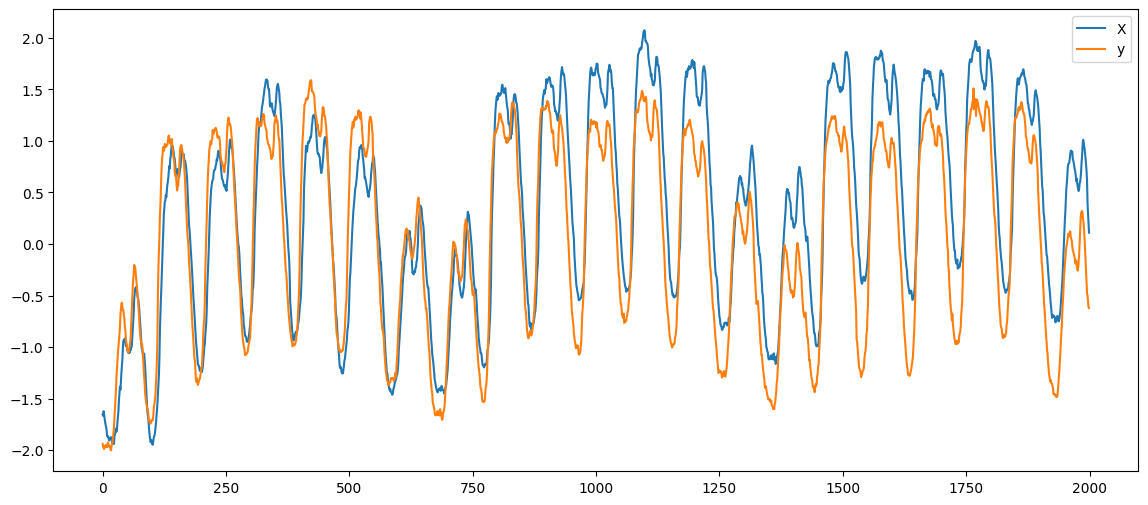

In [22]:
from sklearn.preprocessing import StandardScaler


n_datapoints_per_group = 1000

X_train, X_test, y_train, y_test, X, y = get_data(n_datapoints_per_group, input_cols=['load_last_week'], return_full_data=True)

# standardize everything
scalerX = StandardScaler()
scalerX.fit(X_train)
scalerY = StandardScaler()
scalerY.fit(y_train)

X_train, X_test, X = map(scalerX.transform, (X_train, X_test, X))
y_train, y_test, y = map(scalerY.transform, (y_train, y_test, y))

X_train, X_test, y_train, y_test, X, y = map(lambda arr: torch.Tensor(arr).float(), (X_train, X_test, y_train, y_test, X, y))

print("data shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


def my_plot(X_train, X_test, y_train, y_test):
    num_train_steps = X_train.shape[0]
    num_test_steps = X_test.shape[0]

    x_plot_train = np.arange(num_train_steps)
    x_plot_test = np.arange(num_train_steps, num_train_steps + num_test_steps)
    plt.figure(figsize=(14,6))
    plt.plot(x_plot_train, X_train, label='X_train')
    # plt.scatter(x_plot_train, X_train)
    plt.plot(x_plot_test, X_test, label='X_test')
    plt.plot(x_plot_train, y_train, label='y_train')
    plt.plot(x_plot_test, y_test, label='y_test')
    plt.legend()
    plt.show()

# my_plot(X_train, X_test, y_train, y_test)

def f():
  plt.figure(figsize=(15,6))
  plt.plot(np.arange(X.shape[0]), X, label='X')
  plt.plot(np.arange(X.shape[0]), y, label='y')
  plt.legend()
  plt.show()

f()

In [14]:
display(list(enumerate(X_test[:25])))  # 7-13
display(list(enumerate(y_test[:25])))  # 3-7

[(0, tensor([-1.4345])),
 (1, tensor([-1.4835])),
 (2, tensor([-1.6038])),
 (3, tensor([-1.6335])),
 (4, tensor([-1.6910])),
 (5, tensor([-1.7116])),
 (6, tensor([-1.7711])),
 (7, tensor([-1.8414])),
 (8, tensor([-1.8407])),
 (9, tensor([-1.8618])),
 (10, tensor([-1.8784])),
 (11, tensor([-1.8567])),
 (12, tensor([-1.8498])),
 (13, tensor([-1.8442])),
 (14, tensor([-1.8003])),
 (15, tensor([-1.7700])),
 (16, tensor([-1.7138])),
 (17, tensor([-1.6740])),
 (18, tensor([-1.5551])),
 (19, tensor([-1.4929])),
 (20, tensor([-1.3416])),
 (21, tensor([-1.1231])),
 (22, tensor([-0.6719])),
 (23, tensor([-0.4091])),
 (24, tensor([-0.2026]))]

[(0, tensor([-1.4501])),
 (1, tensor([-1.4937])),
 (2, tensor([-1.5267])),
 (3, tensor([-1.5723])),
 (4, tensor([-1.5623])),
 (5, tensor([-1.5730])),
 (6, tensor([-1.5402])),
 (7, tensor([-1.5231])),
 (8, tensor([-1.5182])),
 (9, tensor([-1.5414])),
 (10, tensor([-1.5135])),
 (11, tensor([-1.4806])),
 (12, tensor([-1.4474])),
 (13, tensor([-1.4021])),
 (14, tensor([-1.3067])),
 (15, tensor([-1.2412])),
 (16, tensor([-1.1424])),
 (17, tensor([-0.9560])),
 (18, tensor([-0.6030])),
 (19, tensor([-0.3970])),
 (20, tensor([-0.1941])),
 (21, tensor([-0.0279])),
 (22, tensor([0.1559])),
 (23, tensor([0.2899])),
 (24, tensor([0.3915]))]

In [5]:
# DEFs

!pip install statsmodels

from statsmodels.tools.eval_measures import mse
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm


def _get_train_loader(X_train, y_train, batch_size):
    try:
        X_train, y_train = map(lambda df: _df_to_tensor(df, dtype=float), (X_train, y_train))
    except AttributeError:
        pass
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    return train_loader

def train_base_model(lr=1e-2):
    dim_in, dim_out = X_train.shape[-1], y_train.shape[-1]
    try:
        X_test_tensor = _df_to_tensor(X_test)
    except AttributeError:
        X_test_tensor = X_test

    model = model_builder(dim_in, hidden_layer_size, dim_out)

    train_loader = _get_train_loader(X_train, y_train, batch_size)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    iterable = tqdm(range(N_EPOCHS)) if verbose else range(N_EPOCHS)
    train_losses, test_losses = [], []
    for it in iterable:
        model.train()
        for loaded_X, loaded_y in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(loaded_X), loaded_y)
            loss.backward()
            optimizer.step()
        try:
            if it % train_loss_iter == 0:
                train_losses.append(loss.item())
            if it % test_loss_iter == 0:
                model.eval()
                with torch.no_grad():
                    test_preds = model(X_test_tensor)  # .detach()
                test_loss = mse(test_preds, y_test).item()
                test_losses.append(test_loss)
        except ZeroDivisionError:
            pass
    model.eval()
    base_model = model
    return base_model, train_losses, test_losses

def plot_training_progress(train_losses, test_losses):
    fig, ax = plt.subplots()
    ax.semilogy(train_losses, label='train')
    ax.semilogy(test_losses, label='test')
    ax.legend()
    plt.show()

def plot_base_performance(y_preds):
    num_train_steps, num_test_steps = X_train.shape[0], X_test.shape[0]

    x_plot_train = np.arange(num_train_steps)
    x_plot_full = np.arange(num_train_steps + num_test_steps)
    x_plot_test = np.arange(num_train_steps, num_train_steps + num_test_steps)
    x_plot_uq = x_plot_full

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))

    ax.plot(x_plot_full, y, color="black", linestyle="dashed", label="True mean")
    # ax.scatter(x_plot_train, y_train, color="black", marker="o", alpha=0.8, label="training points", )

    ax.plot(x_plot_train, X_train, label='X_train')
    ax.plot(x_plot_test, X_test, label='X_test')
    # ax.plot(x_plot_train, y_train, label='y_train')
    # ax.plot(x_plot_test, y_test, label='y_test')

    ax.plot(x_plot_uq, y_preds, label=f"mean/median prediction")#, color="green", )

    ax.legend()
    ax.set_xlabel("data")
    ax.set_ylabel("target")

    # ymin, ymax = -1, 1
    # ax.set_ylim([ymin, ymax])

    plt.show()

100%|██████████| 10000/10000 [04:54<00:00, 33.92it/s]


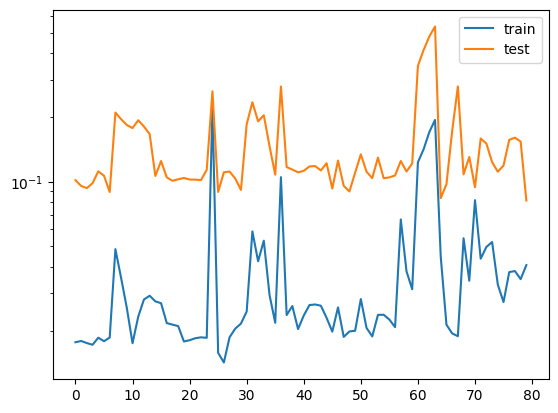

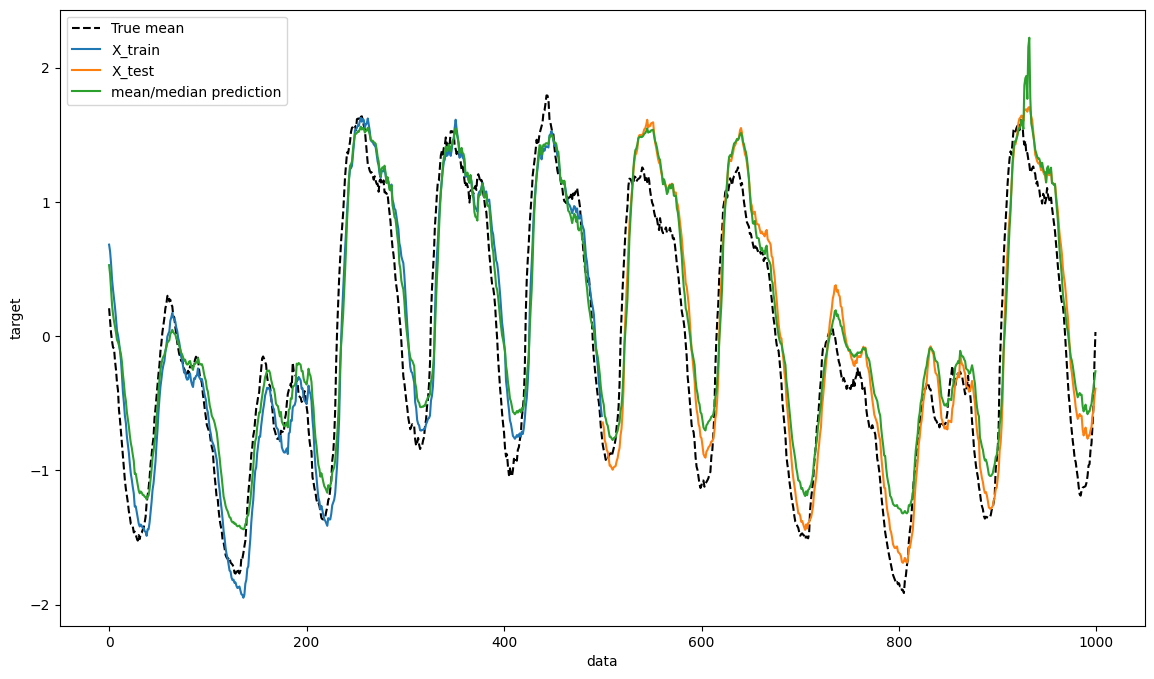

In [7]:
import more_itertools

random_state = 711
N_EPOCHS = 10000
batch_size = 50

verbose = True
hidden_layer_size = 100
num_hidden_layers = 4
activation = torch.nn.LeakyReLU

train_loss_iter = N_EPOCHS // 100
test_loss_iter = train_loss_iter

lr = 1e-2


def model_builder(dim_in, hidden_layer_size, dim_out):
    layers = [torch.nn.Linear(dim_in, hidden_layer_size), activation()]
    layers.append([
        [torch.nn.Linear(hidden_layer_size, hidden_layer_size), activation()]
        for layer in range(num_hidden_layers)
    ])
    layers.append(torch.nn.Linear(hidden_layer_size, dim_out))
    model = torch.nn.Sequential(*more_itertools.collapse(layers))
    model = model.float()
    return model

torch.manual_seed(random_state)

base_model, train_losses, test_losses = train_base_model(lr)
base_model.eval()

loss_skip = 20
plot_training_progress(train_losses[loss_skip:], test_losses[loss_skip:])


def test(X, base_model):
    X_input = X.detach()
    y_preds = base_model(X_input).detach()
    plot_base_performance(y_preds)

test(X, base_model)

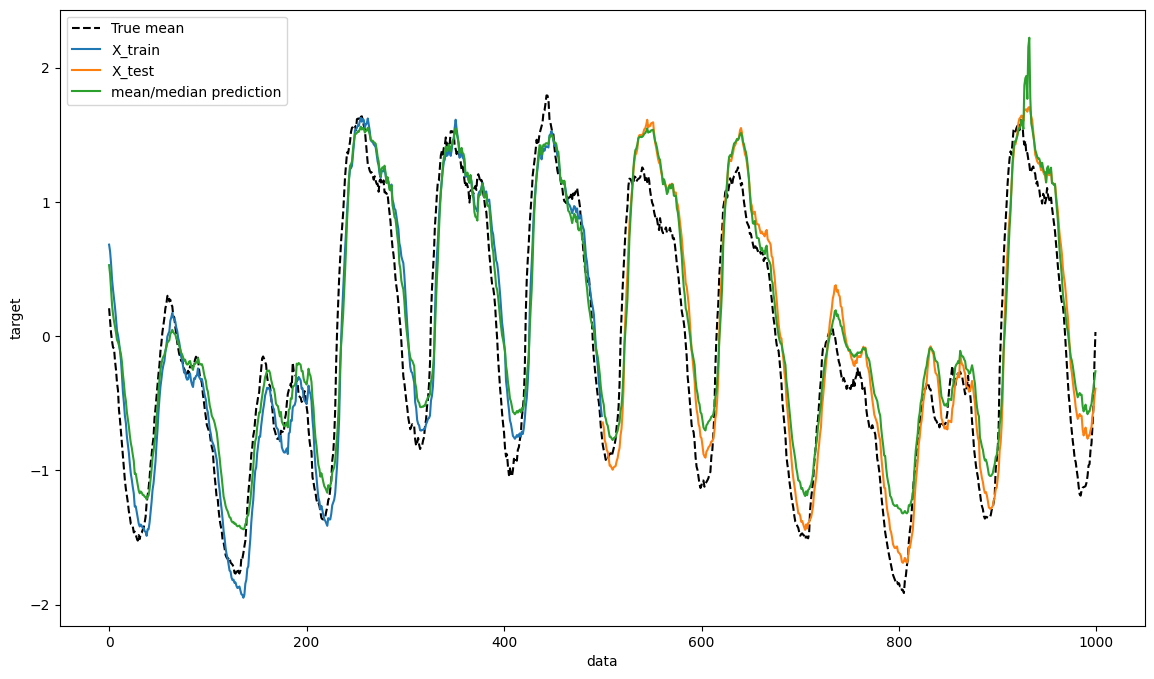

In [8]:
# PLOTS
# plot_training_progress(train_losses, test_losses)


def plot_base_performance2(y_preds):
    num_train_steps, num_test_steps = X_train.shape[0], X_test.shape[0]

    x_plot_train = np.arange(num_train_steps)
    x_plot_full = np.arange(num_train_steps + num_test_steps)
    x_plot_test = np.arange(num_train_steps, num_train_steps + num_test_steps)
    x_plot_uq = x_plot_full

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))

    ax.plot(x_plot_full, y, color="black", linestyle="dashed", label="True mean")
    # ax.scatter(x_plot_train, y_train, color="black", marker="o", alpha=0.8, label="training points", )

    ax.plot(x_plot_train, X_train, label='X_train')
    ax.plot(x_plot_test, X_test, label='X_test')
    # ax.plot(x_plot_train, y_train, label='y_train')
    # ax.plot(x_plot_test, y_test, label='y_test')

    ax.plot(x_plot_uq, y_preds, label=f"mean/median prediction")#, color="green", )

    ax.legend()
    ax.set_xlabel("data")
    ax.set_ylabel("target")

    # ymin, ymax = -1, 1
    # ax.set_ylim([ymin, ymax])

    plt.show()


def test2(X, base_model):
    X_input = X.detach()
    y_preds = base_model(X_input).detach()
    plot_base_performance2(y_preds)


test2(X, base_model)